> Martin Fridrich, 03/2022 

# Final project


In [1]:
# lgbm on gpu
def check_lgbm_gpu():
  import numpy
  import lightgbm
  lightgbm.LGBMClassifier(device="gpu").fit(numpy.array([0,1]).reshape(-1,1),[1,0])
  print("Succes!")
try:
  print("Testing LGBM & GPU compliance...")
  check_lgbm_gpu()
except:
  print("Resolving the issues...")
  !pip uninstall -y lightgbm
  !pip install lightgbm --install-option=--gpu
  check_lgbm_gpu()

Testing LGBM & GPU compliance...
Succes!


In [2]:
# mount project dir
from google.colab import drive
drive.mount("/content/gdrive",  force_remount=True)
%cd gdrive/My Drive/Colab/
#!git clone  https://github.com/fridrichmrtn/hse-advanced-machine-learning
%cd hse-advanced-machine-learning
!git pull
%cd 02_competitive_data_science 
!pip install -r requirements.txt

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab
/content/gdrive/My Drive/Colab/hse-advanced-machine-learning
Updating 2a2e58f..e6771cc
error: Your local changes to the following files would be overwritten by merge:
	02_competitive_data_science/requirements.txt
	02_competitive_data_science/wk06/final_project.ipynb
Please commit your changes or stash them before you merge.
Aborting
/content/gdrive/My Drive/Colab/hse-advanced-machine-learning/02_competitive_data_science


In [3]:
# set kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Personal/.kaggle"
# download data
!mkdir -p data/final_project
%cd data/final_project
!kaggle competitions download -c competitive-data-science-predict-future-sales
# unpack and remove zips
import os
import glob
for f in glob.glob('*.{}'.format("zip")):
  os.system("unzip "+f); os.system("rm "+f)
# get back
%cd /content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science

/content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science/data/final_project
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 160MB/s]
/content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science


## Data loading

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from itertools import product
import re
from fuzzywuzzy import fuzz

In [5]:
DATA_DIR = "data/final_project/"
# sales
sales_train = pd.read_csv(DATA_DIR+"sales_train.csv")
sales_test = pd.read_csv(DATA_DIR+"test.csv")
# addional info
items = pd.read_csv(DATA_DIR+"items.csv")
item_categories = pd.read_csv(DATA_DIR+"item_categories.csv")
shops = pd.read_csv(DATA_DIR+"shops.csv")

# basic stats related to sales tab
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


## Initial transformations

In [6]:
# downcast dataframe
def optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

def optimize_categories(df):
    import pandas as pd
    cat_cols = df.select_dtypes("object").columns
    df[cat_cols] = df[cat_cols].\
        apply(lambda x: x.astype("category").cat.codes)
    return df    

In [7]:
# duplicate shops
shop_duplicates_map = {0: 57, 1: 58, 11: 10, 40: 39}
sales_train["shop_id"] = sales_train["shop_id"].replace(shop_duplicates_map)
# datetime
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")
# filtering on test set
sales_train = sales_train.loc[sales_train.item_id.isin(sales_test["item_id"].unique()), :]
# drop training items with extreme or negative prices or sales counts
sales_train = sales_train[((sales_train["item_price"] > 0) & (sales_train["item_price"] <= 10000)) &
    ((sales_train["item_cnt_day"] > 0) & (sales_train["item_cnt_day"] <= 1000))]
# test-based cartesian product & inds
sales_index = pd.DataFrame(product(sales_test.item_id.unique(), sales_test.shop_id.unique(),
    range(35)),columns = ["item_id", "shop_id", "date_block_num"])
sales_index = optimize_numeric_dtypes(sales_index)
# sales table
sales_train["revenue"] = sales_train["item_price"]*sales_train["item_cnt_day"]
sales = sales_train.groupby(["shop_id", "item_id", "date_block_num"], as_index=False).agg(
    total_sold=("item_cnt_day", sum),  sum_revenue=("revenue",sum),
    n_transactions = ("item_cnt_day",pd.Series.count))\
        .sort_values("date_block_num")
sales = sales_index.merge(sales, how="left",
    on=["shop_id", "item_id", "date_block_num"])
sales["date_block_num"].fillna(34, inplace=True)
sales.loc[sales.date_block_num<34, ["total_sold", "sum_revenue", "n_transactions"]]=\
    sales.loc[sales.date_block_num<34, ["total_sold", "sum_revenue", "n_transactions"]].fillna(0)
sales = optimize_numeric_dtypes(sales)
del sales_train, sales_test, sales_index; gc.collect(); sales.head(3) 

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions
0,5037,5,0,0.0,0.0,0.0
1,5037,5,1,0.0,0.0,0.0
2,5037,5,2,0.0,0.0,0.0


## Exploration

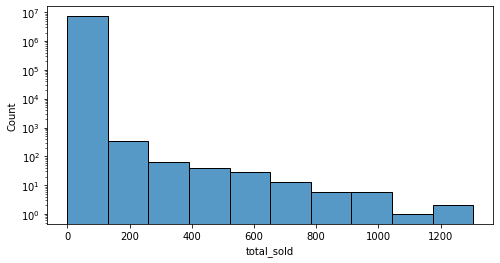

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
hist = sns.histplot(data=sales, x="total_sold", bins=10,
    palette=sns.color_palette("husl"))
hist.set_yscale("log")

In [9]:
# top 5 items
sales.groupby("item_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

item_id
20949    154788.0
2808      14016.0
3732      13630.0
17717     13547.0
5822      12303.0
Name: total_sold, dtype: float32

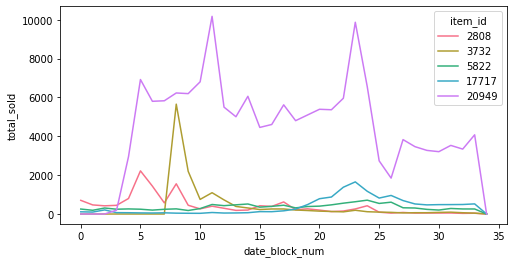

In [10]:
# targets per top 5 items over time
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data=sales[sales.item_id.isin([20949,2808,3732,17717,5822])].\
        groupby(["item_id","date_block_num"], as_index=False)["total_sold"].sum(),
    x="date_block_num", y="total_sold", hue="item_id",
    palette=sns.color_palette("husl", 5));    

In [11]:
# top 5 shops
sales.groupby("shop_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

shop_id
31    159630.0
25    123075.0
28     99593.0
42     82364.0
57     69515.0
Name: total_sold, dtype: float32

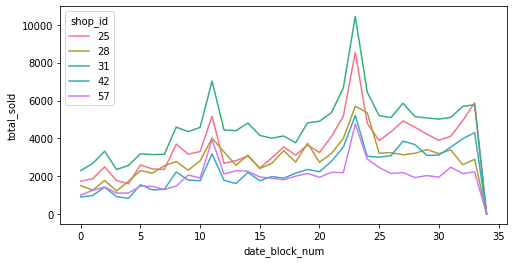

In [12]:
# targets per top 5 items over time
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data=sales[sales.shop_id.isin([31,25,28,42,57])].\
        groupby(["shop_id","date_block_num"], as_index=False)["total_sold"].sum(),
    x="date_block_num", y="total_sold", hue="shop_id",
    palette=sns.color_palette("husl", 5));    

In [13]:
# top 5 categories
sales.merge(items).groupby("item_category_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

item_category_id
30    221393.0
55    179639.0
40    156374.0
71    154788.0
19    110244.0
Name: total_sold, dtype: float32

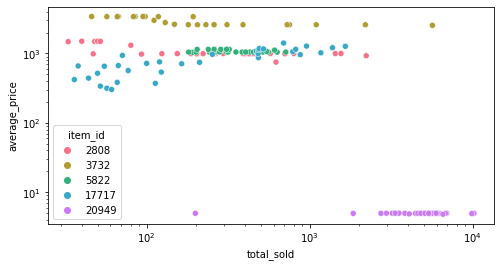

In [14]:
# price vs sales, demand almost inelastic
df = sales[sales.item_id.isin([20949,2808,3732,17717,5822])].\
        groupby(["item_id", "date_block_num"], as_index=False).\
            agg(sum_revenue=("sum_revenue",sum),
            total_sold=("total_sold",sum))
df["average_price"] = df.sum_revenue/df.total_sold
fig, ax = plt.subplots(1,1,figsize=(8,4))
scatter = sns.scatterplot(data=df, x="total_sold", y="average_price",
    hue="item_id", palette=sns.color_palette("husl", 5));
scatter.set_yscale("log"); scatter.set_xscale("log");

## Feature engineering

In [15]:
# item groups based on adjacency and label similarity
items.item_name = items.item_name.apply(lambda x: re.sub("[^A-ZА-Яa-zа-я0-9 ]","", x))
items.item_name = items.item_name.apply(lambda x: re.sub("\\s+"," ", x))
item_names = pd.concat([items.item_id, items.item_name,
    items.item_id.shift().fillna(0), items.item_name.shift().fillna("")], axis=1)
item_names.columns = ["item_id", "item_name", "previous_item_id", "previous_item_name"]
item_names["similarity"] = item_names.apply(\
     lambda x: fuzz.ratio(x["item_name"],x["previous_item_name"]), axis=1)
item_names["group_start"] = item_names["similarity"] <= 75
item_group_map = item_names.loc[item_names.group_start, ["item_id"]]
item_group_map.columns = ["group_start"]
item_group_map["group_end"] = item_group_map["group_start"].shift(-1).\
    fillna(item_group_map["group_start"].max()+1).astype("int")
item_group_map["item_sim_id"] = list(range(len(item_group_map)))
# remap
items = items.merge(item_group_map, how="left",
    left_on=["item_id"], right_on=["group_start"])
items = items.sort_values("item_id")
items["item_sim_id"] = items["item_sim_id"].fillna(method="ffill").astype("int")
del item_names, item_group_map; gc.collect()
items = items[["item_id","item_name", "item_category_id", "item_sim_id"]]
# name length
items["item_name_len"] = items.item_name.apply(len).astype("int16")
items.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,item_id,item_name,item_category_id,item_sim_id,item_name_len
0,0,ВО ВЛАСТИ НАВАЖДЕНИЯ ПЛАСТ D,40,0,29
1,1,ABBYY FineReader 12 Professional Edition Full ...,76,1,64
2,2,В ЛУЧАХ СЛАВЫ UNV D,40,2,19


In [16]:
# categories
cat_splits = item_categories.item_category_name.apply(lambda x: x.split(" - "))
item_categories = pd.concat([item_categories,
    pd.DataFrame([c if len(c)>1 else [c[0],""] for c in cat_splits],
        columns=["parent_cat","child_cat"])], axis=1)
items = items.merge(item_categories, how="inner")
# return categorical encoding
items = optimize_categories(items[["item_id", "item_category_id", "item_sim_id",
    "item_name_len", "parent_cat", "child_cat"]])
# add categories
sales = sales.merge(items, how="inner", on="item_id")
del item_categories, items; gc.collect(); sales.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat
0,5037,5,0,0.0,0.0,0.0,19,3286,27,5,13
1,5037,5,1,0.0,0.0,0.0,19,3286,27,5,13
2,5037,5,2,0.0,0.0,0.0,19,3286,27,5,13


In [17]:
# date features
def working_days_count(from_date, to_date=None):
    import pandas as pd
    if to_date is None:
        to_date=from_date+pd.DateOffset(months=1)
    temp_date=from_date
    cnt=0
    while temp_date<to_date:
        if temp_date.weekday()<5:
            cnt+=1
        temp_date+=pd.DateOffset(days=1)
    return ((to_date-from_date).days, cnt, (to_date-from_date).days-cnt)
dates = pd.DataFrame(sales.date_block_num.unique(), columns=["date_block_num"])
dates["date"] = dates["date_block_num"].apply(lambda x: pd.to_datetime("01/01/2013")+\
    pd.DateOffset(months=x))
dates["year"] = dates.date.dt.year
dates["month"] = dates.date.dt.month
dates = optimize_numeric_dtypes(pd.concat([dates, pd.DataFrame.from_records(
        dates["date"].apply(lambda x: working_days_count(x)),
    columns=["total_days", "working_days", "weekend_days"])], axis=1))
sales = sales.merge(dates[["date_block_num","year","month","total_days", "working_days",
    "weekend_days"]], how="inner", on="date_block_num")
del dates; gc.collect(); sales.tail(3)    

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,year,month,total_days,working_days,weekend_days
7496997,969,44,34,NaN,NaN,NaN,37,646,20,11,2,2015,11,30,21,9
7496998,969,39,34,NaN,NaN,NaN,37,646,20,11,2,2015,11,30,21,9
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,2,2015,11,30,21,9


In [18]:
# pricing overall and inside cat
item_pricing = sales.groupby(["date_block_num","item_id","item_category_id"], as_index=False).\
    agg(total_sold=("total_sold", sum),  sum_revenue=("sum_revenue",sum))
train_ind = item_pricing.date_block_num<34
item_pricing.loc[train_ind,"average_price"] = item_pricing["sum_revenue"]/item_pricing["total_sold"]
item_pricing.loc[train_ind,"average_price"]  = item_pricing.groupby(["item_id"])["average_price"].\
    apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
# add price changes
item_pricing.loc[train_ind,"price_change"] = item_pricing.groupby(["item_id"])["average_price"].\
    apply(lambda x: x/x.shift()).fillna(-1)
# add position within the category
item_pricing.loc[train_ind,"price_perc"] = item_pricing.groupby(["item_category_id", "date_block_num"])\
    ["average_price"].apply(lambda x: x.rank(pct=True)).fillna(-1)
item_pricing = optimize_numeric_dtypes(item_pricing[["date_block_num", "item_id", "price_change",
    "price_perc"]])
sales = sales.merge(item_pricing, how="left",
    on=["date_block_num", "item_id"])
del item_pricing; gc.collect(); sales.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,year,month,total_days,working_days,weekend_days,price_change,price_perc
7496997,969,44,34,NaN,NaN,NaN,37,646,20,11,2,2015,11,30,21,9,NaN,NaN
7496998,969,39,34,NaN,NaN,NaN,37,646,20,11,2,2015,11,30,21,9,NaN,NaN
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,2,2015,11,30,21,9,NaN,NaN


In [19]:
# shop location
shops["city_id"] = shops.shop_name.apply(lambda x:\
    re.sub("[^A-ZА-Яa-zа-я0-9 ]","", x.split(" ")[0]))
shops = optimize_categories(shops[["shop_id", "city_id"]])
sales = sales.merge(shops, how="inner", on="shop_id")
del shops; gc.collect(); sales.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,year,month,total_days,working_days,weekend_days,price_change,price_perc,city_id
7496997,15757,45,34,NaN,NaN,NaN,55,10515,33,13,5,2015,11,30,21,9,NaN,NaN,20
7496998,19648,45,34,NaN,NaN,NaN,40,13125,25,11,7,2015,11,30,21,9,NaN,NaN,20
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,2,2015,11,30,21,9,NaN,NaN,20


In [20]:
# time-series
# smoothed demand across various perspectives
train_ind = sales.date_block_num<34
# city
sales.loc[train_ind, "city_demand"] = sales[train_ind].\
    groupby(["city_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# shop
sales.loc[train_ind, "shop_demand"] = sales[train_ind].\
    groupby(["shop_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# categories
sales.loc[train_ind, "cat_demand0"] = sales[train_ind].\
    groupby(["parent_cat","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# categories
sales.loc[train_ind, "cat_demand1"] = sales[train_ind].\
    groupby(["child_cat","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")      
# categories
sales.loc[train_ind, "cat_demand2"] = sales[train_ind].\
    groupby(["item_sim_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")        
# item
sales.loc[train_ind, "item_demand"] = sales[train_ind].\
    groupby(["item_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# item maturity
sales["item_maturity"] = (sales["date_block_num"] - sales[["item_id","date_block_num"]].merge(\
    sales[sales.n_transactions>0].groupby("item_id", as_index=False).\
        agg(date_block_num_min=("date_block_num",min)),
            how="left")["date_block_num_min"]).clip(-1,34).fillna(-1)
del train_ind; gc.collect();
sales = optimize_numeric_dtypes(sales)
sales.tail(3)

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,...,price_change,price_perc,city_id,city_demand,shop_demand,cat_demand0,cat_demand1,cat_demand2,item_demand,item_maturity
7496997,15757,45,34,NaN,NaN,NaN,55,10515,33,13,...,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,34.0
7496998,19648,45,34,NaN,NaN,NaN,40,13125,25,11,...,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,11.0
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,...,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,17.0


In [21]:
lag_steps = [1,2,3]
lag_fill = {"total_sold":0, "sum_revenue":0, "n_transactions":0, "price_change":1, "price_perc":-1,
    "city_demand":0, "shop_demand":0, "cat_demand0":0,"cat_demand1":0,"cat_demand2":0, "item_demand":0}
for l in lag_steps:
    for c in lag_fill.keys():
        sales.loc[:,"lag"+str(l)+"_"+c] = sales.groupby([sales.shop_id,sales.item_id])\
            [c].shift(l).fillna(lag_fill[c])
#sales = sales[sales.date_block_num>25] # just reduce the dataset
target = "total_sold"
col_fil = [c for c in sales.columns if (c not in lag_fill.keys()) or (c ==target)]
sales = optimize_numeric_dtypes(sales.loc[:,col_fil])
sales.head(3)

,item_id,shop_id,date_block_num,total_sold,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,year,...,lag3_sum_revenue,lag3_n_transactions,lag3_price_change,lag3_price_perc,lag3_city_demand,lag3_shop_demand,lag3_cat_demand0,lag3_cat_demand1,lag3_cat_demand2,lag3_item_demand
0,5037,5,0,0.0,19,3286,27,5,13,2013,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5320,5,0,0.0,55,3489,28,13,5,2013,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5233,5,0,0.0,19,3438,51,5,13,2013,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# col filters
target = "total_sold"
cat_cols = ["item_name_len", "item_sim_id", "parent_cat", "child_cat",
    "year", "month", "total_days", "working_days", "weekend_days", "city_id"]
num_cols = [f for f in sales.columns if (f not in cat_cols) &\
  (f not in [target, "item_id", "shop_id", "date_block_num"])]
features = cat_cols + num_cols
# target clippin
sales[target] = sales[target].clip(0,20)

In [48]:
# kfold mean encoding with smoothing
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
for train_ind, test_ind in kf.split(sales):
  te = TargetEncoder(cols=cat_cols, smoothing=1.0, min_samples_leaf=5*10**3)
  te.fit(sales.loc[train_ind,cat_cols], sales.loc[train_ind,target])
  sales.loc[test_ind, cat_cols] = te.transform(sales.loc[test_ind,cat_cols], sales.loc[test_ind,target])
del kf, te, train_ind, test_ind; gc.collect();  

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Modeling pipeline

In [89]:
import lightgbm as lgbm
import catboost as cat
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [82]:
# stage filters
b_ind =  sales.date_block_num==32 # 2nd stage 
c_ind =  sales.date_block_num==33 # eval
test_ind =  sales.date_block_num==34 # prediction
a_ind = ~b_ind & ~c_ind & ~test_ind # 1st stage

In [66]:
#b_ind =  sales.date_block_num==33 # 2nd stage 
#c_ind =  sales.date_block_num==33 # eval
#test_ind =  sales.date_block_num==34 # prediction
#a_ind = ~b_ind & ~c_ind & ~test_ind # 1st stage

### First stage models

In [83]:
# lightgbm
lgbm_model = lgbm.LGBMRegressor(n_estimators=2000, learning_rate=.001,
  objective="rmse", device="gpu")
lgbm_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target],
  eval_set=(sales.loc[b_ind,features], sales.loc[b_ind,target]),
  callbacks=[lgbm.early_stopping(stopping_rounds=10)])

# pushout preds
lgbm_b_feature = lgbm_model.predict(sales.loc[b_ind,features]).clip(0,20)
lgbm_c_feature = lgbm_model.predict(sales.loc[c_ind,features]).clip(0,20)
lgbm_test_feature = lgbm_model.predict(sales.loc[test_ind,features]).clip(0,20)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 0.842195


In [84]:
# light rf
rf_model = lgbm.LGBMRegressor(n_estimators=2000,
  boosting_type="rf", bagging_freq=5, subsample_freq=1,
  bagging_fraction=.5, subsample=.632,
  objective="rmse", device="gpu")
rf_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target],
  eval_set=(sales.loc[b_ind,features], sales.loc[b_ind,target]),
  callbacks=[lgbm.early_stopping(stopping_rounds=10)])

# pushout preds
rf_b_feature = rf_model.predict(sales.loc[b_ind,features]).clip(0,20)
rf_c_feature = rf_model.predict(sales.loc[c_ind,features]).clip(0,20)
rf_test_feature = rf_model.predict(sales.loc[test_ind,features]).clip(0,20)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5 will be ignored. Current value: bagging_fraction=0.5
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.867084


In [85]:
# catboost on raw data
cat_model = cat.CatBoostRegressor(iterations=2000,
  learning_rate=.001, verbose=100,
  eval_metric="RMSE", early_stopping_rounds=10, task_type="GPU")
cat_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target],
  eval_set=(sales.loc[b_ind,features], sales.loc[b_ind,target]))

# pushout preds
cat_b_feature = cat_model.predict(sales.loc[b_ind,features]).clip(0,20)
cat_c_feature = cat_model.predict(sales.loc[c_ind,features]).clip(0,20)
cat_test_feature = cat_model.predict(sales.loc[test_ind,features]).clip(0,20)

0:	learn: 1.0374742	test: 1.1170423	best: 1.1170423 (0)	total: 45.1ms	remaining: 1m 30s
100:	learn: 0.9973839	test: 1.0834367	best: 1.0834367 (100)	total: 3.57s	remaining: 1m 7s
200:	learn: 0.9627834	test: 1.0549948	best: 1.0549948 (200)	total: 7.11s	remaining: 1m 3s
300:	learn: 0.9328159	test: 1.0309435	best: 1.0309435 (300)	total: 10.7s	remaining: 1m
400:	learn: 0.9069798	test: 1.0103486	best: 1.0103486 (400)	total: 14.3s	remaining: 56.9s
500:	learn: 0.8847008	test: 0.9928407	best: 0.9928407 (500)	total: 17.9s	remaining: 53.6s
600:	learn: 0.8656707	test: 0.9781692	best: 0.9781692 (600)	total: 21.5s	remaining: 50.1s
700:	learn: 0.8492523	test: 0.9655761	best: 0.9655761 (700)	total: 25.2s	remaining: 46.6s
800:	learn: 0.8352163	test: 0.9548756	best: 0.9548756 (800)	total: 28.8s	remaining: 43.1s
900:	learn: 0.8230707	test: 0.9455502	best: 0.9455502 (900)	total: 32.5s	remaining: 39.6s
1000:	learn: 0.8124982	test: 0.9373020	best: 0.9373020 (1000)	total: 36.2s	remaining: 36.1s
1100:	learn: 

In [117]:
# catboost clf
clf_target = (sales.loc[:,target]>1).fillna(0).astype("int")
catclf_model = cat.CatBoostClassifier(iterations=2000,
  learning_rate=.001, verbose=100, early_stopping_rounds=10,
  eval_metric="F1", task_type="GPU")
catclf_model.fit(sales.loc[a_ind,features], clf_target[a_ind],
  eval_set=(sales.loc[b_ind,features], clf_target[b_ind]))

# pushout preds
catclf_b_feature = catclf_model.predict(sales.loc[b_ind,features]).reshape(1,-1)[0]
catclf_c_feature = catclf_model.predict(sales.loc[c_ind,features]).reshape(1,-1)[0]
catclf_test_feature = catclf_model.predict(sales.loc[test_ind,features]).reshape(1,-1)[0]

0:	learn: 0.4455303	test: 0.3904542	best: 0.3904542 (0)	total: 49.7ms	remaining: 1m 39s
bestTest = 0.3963480129
bestIteration = 25
Shrink model to first 26 iterations.


In [ ]:
# reformulate as rank/multiclass
#lgbmc_model = lgbm.LGBMRanker(n_estimators=1000, learning_rate=.01,
#  device="gpu")
#lgbmc_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target],
#  eval_set=(sales.loc[b_ind,features], sales.loc[b_ind,target]),
#  callbacks=[lgbm.early_stopping(stopping_rounds=10)])

#clf_target = (sales[target]>1).astype("int")
#clf_target = (sales.loc[a_ind,target].rank(pct=True).round(1)*10).astype("int")
#lgbmc_model.fit(sales.loc[a_ind,features], clf_target[a_ind])

# pushout preds
#lgbmc_b_feature = lgbmc_model.predict(sales.loc[b_ind,features])
#lgbmc_c_feature = lgbmc_model.predict(sales.loc[c_ind,features])
#lgbmc_test_feature = lgbmc_model.predict(sales.loc[test_ind,features])

### Second stage model

In [120]:
from sklearn.tree import DecisionTreeRegressor

In [137]:
b_features = np.vstack([rf_b_feature, lgbm_b_feature,
    cat_b_feature, catclf_b_feature], axis=1)
c_features = np.stack([rf_c_feature, lgbm_c_feature,
    cat_c_feature, catclf_c_feature], axis=1)
test_features = np.stack([rf_test_feature, lgbm_test_feature,
    cat_test_feature, catclf_test_feature], axis=1)

lr_model = LinearRegression()
lr_model.fit(b_features, sales.loc[b_ind,target])

train_rsme = np.mean((lr_model.predict(b_features).clip(0,20)-sales.loc[b_ind,target])**2)**(1/2)
val_rsme = np.mean((lr_model.predict(c_features).clip(0,20)-sales.loc[c_ind,target])**2)**(1/2)
print("Stacked pipeline> RMSE on train set: {}; on val set: {}".format(train_rsme, val_rsme))

TypeError: ignored

In [132]:
test_mapping = pd.read_csv(DATA_DIR+"test.csv")
test_predictions = sales.loc[test_ind,["item_id", "shop_id"]]
test_predictions["item_cnt_month"] = lr_model.predict(test_features).clip(0,20)
test_predictions = test_mapping.merge(test_predictions, on=["item_id", "shop_id"],how="left").fillna(0)
test_predictions[["ID", "item_cnt_month"]].to_csv("data/submissions/submission.csv", index=False)
#!kaggle competitions submit -c competitive-data-science-predict-future-sales -f data/submissions/submission.csv -m "Meh, but now with LP."

## Submission